<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



### Model-2

<pre>
1.LSTM after removing the Low and High idf value words. (In model-1 Trained on total data but in Model-2 trained on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>

In [1]:
##importing all required modules
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv1D, MaxPooling1D,concatenate,BatchNormalization,Activation,Dropout,Input,Flatten,Embedding,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
final = pd.read_csv("lstm_preprocessed_data.csv")
final.shape

(109248, 9)

In [3]:
"""final_neg = final[final["project_is_approved"] == 0]
final_pos = final[final["project_is_approved"] == 1]

lst_ran = []
for i in range(10000):
    lst_ran.append(final_neg.iloc[i])
    lst_ran.append(final_pos.iloc[-i])
    
project_data = pd.DataFrame(lst_ran)
project_data.shape"""
project_data = final

In [4]:
project_data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [5]:
from sklearn.model_selection import train_test_split

project_data_train, project_data_test, y_train, y_test = train_test_split(project_data, project_data["project_is_approved"], test_size=0.2, stratify=project_data["project_is_approved"], random_state = 0)

print("Number of data points in train data", project_data_train.shape)
print('-'*50)
print("Number of data points in test data", project_data_test.shape)
print('-'*50)

Number of data points in train data (87398, 9)
--------------------------------------------------
Number of data points in test data (21850, 9)
--------------------------------------------------


# One Hot Encoding

## Categorical Features

In [6]:
val = dict(project_data_train["clean_categories"].value_counts())
val_d = dict(enumerate(val.keys()))
category_val = {v: k for k, v in val_d.items()}

cate_train = project_data_train["clean_categories"].values
category_train = []
for i in  cate_train:
    category_train.append(category_val[i])
    
cate_test = project_data_test["clean_categories"].values
category_test = []
for i in  cate_test:
    if i in category_val:
        category_test.append(category_val[i])
    else:
        category_test.append(len(val_d.keys()))

category_train = np.array(category_train)
category_test = np.array(category_test)

In [7]:
val = dict(project_data_train["clean_subcategories"].value_counts())
val_d = dict(enumerate(val.keys()))
subcategory_val = {v: k for k, v in val_d.items()}

subcate_train = project_data_train["clean_subcategories"].values
subcategory_train = []
for i in  subcate_train:
    subcategory_train.append(subcategory_val[i])
    
subcate_test = project_data_test["clean_subcategories"].values
subcategory_test = []
for i in  subcate_test:
    if i in subcategory_val:
        subcategory_test.append(subcategory_val[i])
    else:
        subcategory_test.append(len(val_d.keys()))
        
subcategory_train = np.array(subcategory_train)
subcategory_test = np.array(subcategory_test)

In [8]:
val = dict(project_data_train["school_state"].value_counts())
val_d = dict(enumerate(val.keys()))
state_val = {v: k for k, v in val_d.items()}

state_tr = project_data_train["school_state"].values
state_enc_train = []
for i in  state_tr:
    state_enc_train.append(state_val[i])
    
state_te = project_data_test["school_state"].values
state_enc_test = []
for i in  state_te:
    if i in state_val:
        state_enc_test.append(state_val[i])
    else:
        state_enc_test.append(len(val_d.keys()))
        
state_enc_train = np.array(state_enc_train)
state_enc_test = np.array(state_enc_test)

In [9]:
val = dict(project_data_train["project_grade_category"].value_counts())
val_d = dict(enumerate(val.keys()))
grade_val = {v: k for k, v in val_d.items()}

grade_train = project_data_train["project_grade_category"].values
grade_enc_train = []
for i in  grade_train:
    grade_enc_train.append(grade_val[i])
    
grade_test = project_data_test["project_grade_category"].values
grade_enc_test = []
for i in  grade_test:
    if i in grade_val:
        grade_enc_test.append(grade_val[i])
    else:
        grade_enc_test.append(len(val_d.keys()))
        
grade_enc_train = np.array(grade_enc_train)
grade_enc_test = np.array(grade_enc_test)

In [10]:
val = dict(project_data_train["teacher_prefix"].value_counts())
val_d = dict(enumerate(val.keys()))
prefix_val = {v: k for k, v in val_d.items()}

prefix_train = project_data_train["teacher_prefix"].values
prefix_enc_train = []
for i in  prefix_train:
    prefix_enc_train.append(prefix_val[i])
    
prefix_test = project_data_test["teacher_prefix"].values
prefix_enc_test = []
for i in  prefix_test:
    if i in prefix_val:
        prefix_enc_test.append(prefix_val[i])
    else:
        prefix_enc_test.append(len(val_d.keys()))
        
prefix_enc_train = np.array(prefix_enc_train)
prefix_enc_test = np.array(prefix_enc_test)

## Text Data

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

essay_train = project_data_train["essay"].values
essay_test = project_data_test["essay"].values

t = Tokenizer()
t.fit_on_texts(essay_train)
vocab_size = len(t.word_index) + 1

In [12]:
# integer encode the documents
#Train
enc_docs_train = t.texts_to_sequences(essay_train)
print(enc_docs_train[1])

[175, 20, 23, 2131, 53, 80, 14, 491, 312, 10, 1600, 457, 3729, 116, 10, 25, 1510, 292, 1, 816, 3, 30, 182, 840, 344, 4, 1, 6163, 1263, 547, 142, 1897, 4, 1, 1853, 1176, 880, 10, 14, 2480, 391, 160, 284, 4, 1, 40, 67, 26, 6, 1480, 1603, 463, 1824, 78, 6, 1441, 14, 1441, 44, 88, 102, 9, 3465, 14, 46, 32, 8818, 346, 8986, 38, 32, 101, 46, 827, 32, 6, 167, 98, 33016, 54, 2, 34, 153, 2720, 3254, 3692, 231, 487, 376, 32, 2, 34, 1, 407, 538, 5053, 2705, 57, 118, 14, 15, 2852, 33, 1519, 14, 115, 5, 33, 2852, 193, 4, 1, 28, 15, 2346, 2519, 664, 1894, 3649, 530, 142, 13]


In [13]:
#Test
enc_docs_test = t.texts_to_sequences(essay_test)
print(enc_docs_test[1])

[14, 492, 20, 70, 26, 120, 864, 146, 4, 1, 19, 6164, 968, 624, 65, 1052, 118, 4578, 6, 7897, 2433, 161, 194, 20, 14, 19, 792, 73, 854, 109, 686, 14, 19, 17, 337, 23, 767, 1236, 74, 102, 241, 32, 69, 4, 23, 26, 373, 6, 4280, 14, 347, 50, 132, 138, 1, 169, 67, 273, 414, 680, 206, 3, 115, 216, 352, 623, 39, 1, 295, 48, 429, 6173, 110, 65, 41, 26, 638, 1047, 944, 1, 67, 134, 1526, 422, 125, 26, 38, 118, 791, 101, 160, 4318, 68, 309, 242, 207, 472, 1519, 4467, 4368, 1212, 3172, 19404, 50, 330, 32, 1941, 288, 1, 25, 23, 46, 32, 131, 2491, 303, 1941, 288, 68, 309, 203, 255, 1222, 1184, 32, 28, 49, 1313, 186, 2254, 3771, 202, 2712, 45, 15, 186, 2375, 159, 27, 100, 15, 10, 17, 102, 2, 89, 40, 3618, 1950, 23, 46, 32, 131, 13]


In [14]:
# truncate and/or pad input sequences
max_review_length = 400
pad_docs_train = pad_sequences(enc_docs_train, maxlen=max_review_length)
pad_docs_test = pad_sequences(enc_docs_test, maxlen=max_review_length)

print(pad_docs_train.shape)
print(pad_docs_train[10])

(87398, 400)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [15]:
"""# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
glovemodel = loadGloveModel('glove.42B.300d.txt')"""

Loading Glove Model
Done. 1917495  words loaded!


In [16]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = glovemodel.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Numerical Features

In [17]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data_train['price'].values.reshape(-1, 1))

Mean : 298.3417191468912, Standard deviation : 365.8936474660223


In [18]:
from sklearn.preprocessing import StandardScaler


price_scalar = StandardScaler()
price_scalar.fit(project_data_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized_test = price_scalar.transform(project_data_test['price'].values.reshape(-1, 1))

Mean : 298.3417191468912, Standard deviation : 365.8936474660223


In [19]:
from sklearn.preprocessing import StandardScaler
import warnings
previouspro_scalar = StandardScaler()
previouspro_scalar.fit(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {previouspro_scalar.mean_[0]}, Standard deviation : {np.sqrt(previouspro_scalar.var_[0])}")


previouspro_standardized_train = previouspro_scalar.transform(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
warnings.filterwarnings("ignore")

Mean : 11.131524748850088, Standard deviation : 27.733763561081116


In [20]:
from sklearn.preprocessing import StandardScaler

previouspro_scalar = StandardScaler()
previouspro_scalar.fit(project_data_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {previouspro_scalar.mean_[0]}, Standard deviation : {np.sqrt(previouspro_scalar.var_[0])}")


previouspro_standardized_test = previouspro_scalar.transform(project_data_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
warnings.filterwarnings("ignore")

Mean : 11.131524748850088, Standard deviation : 27.733763561081116


In [21]:
remain_train = np.stack((price_standardized, previouspro_standardized_train), axis=-1)
remain_train = remain_train.reshape(remain_train.shape[0], remain_train.shape[1]*remain_train.shape[2])
remain_test = np.stack((price_standardized_test, previouspro_standardized_test), axis=-1)
remain_test = remain_test.reshape(remain_test.shape[0], remain_test.shape[1]*remain_test.shape[2])

# Model 1

In [27]:
tf.keras.backend.clear_session()

Input_model_1 = Input(shape=(max_review_length,) ,name="Text_data")
layer11 = Embedding(vocab_size, 300 ,weights=[embedding_matrix],trainable=False ,name="layer11")(Input_model_1)
layer21 = LSTM(units = 100,activation='relu',kernel_initializer='he_normal',return_sequences = False,name="layer21")(layer11)
layer31 = Flatten()(layer21)

Input_model_2 = Input(shape=(1,),name="School_state")
layer12 = Embedding(len(state_val) + 1, 32 ,name="layer12")(Input_model_2)
layer22 = Flatten()(layer12)

Input_model_3 = Input(shape=(1,),name="Grade")
layer13 = Embedding(len(grade_val) + 1, 32 ,name="layer13")(Input_model_3)
layer23 = Flatten()(layer13)

Input_model_4 = Input(shape=(1,),name="Categories")
layer14 = Embedding(len(category_val) + 1, 32 ,name="layer14")(Input_model_4)
layer24 = Flatten()(layer14)

Input_model_5 = Input(shape=(1,),name="sub_Category")
layer15 = Embedding(len(subcategory_val) + 1, 32 ,name="layer15")(Input_model_5)
layer25 = Flatten()(layer15)

Input_model_6 = Input(shape=(1,),name="Prefix")
layer16 = Embedding(len(prefix_val) + 1, 32 ,name="layer16")(Input_model_6)
layer26 = Flatten()(layer16)

Input_model_7 = Input(shape=(2,),name="Remaining_features")
layer27 = Dense(units=8,activation='relu',kernel_initializer="he_normal",name="layer27")(Input_model_7)

concat_layer = concatenate(inputs=[layer31,layer22,layer23,layer24,layer25,layer26,layer27],name="concat")

layer2 = Dense(units=512,activation='relu',kernel_initializer='he_normal',name="layer2")(concat_layer)
norm_1 = BatchNormalization()(layer2)
layer3 = Dropout(0.25)(norm_1)
layer4 = Dense(units=256,activation='relu',kernel_initializer='he_normal',name="layer4")(layer3)
norm_2 = BatchNormalization()(layer4)
layer5 = Dense(units=128,activation='relu',kernel_initializer='he_normal',name="layer5")(norm_2)
norm_3 = BatchNormalization()(layer5)
layer6 = Dense(units=64,activation='relu',kernel_initializer='he_normal',name="layer6")(norm_3)

output = Dense(units=1,activation='sigmoid',kernel_initializer="glorot_uniform",name="output")(layer6)

model = Model(inputs=[Input_model_1,Input_model_2,Input_model_3,Input_model_4,Input_model_5,Input_model_6,Input_model_7],outputs=output)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_data (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
layer11 (Embedding)             (None, 400, 300)     15540900    Text_data[0][0]                  
__________________________________________________________________________________________________
School_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Grade (InputLayer)              [(None, 1)]          0                                            
______________________________________________________________________________________________

In [29]:
from sklearn.metrics import roc_auc_score
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [30]:
#compile 
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [31]:
"""class_weights = {0 : 1,
                 1 :0.2}"""

'class_weights = {0 : 1,\n                 1 :0.2}'

In [32]:
from time import time
logs = r"C:\Users\Dewang\Desktop\AAIC notes\0.0 Assignments\AAIC classroom Assignments\logs\ex1"
tensorboard = TensorBoard(log_dir = logs )

In [34]:
#train
model.fit([pad_docs_train,state_enc_train,grade_enc_train,category_train,subcategory_train,prefix_enc_train,remain_train],y_train,
           batch_size=256,epochs=10,
           validation_data= ([pad_docs_test,state_enc_test,grade_enc_test,category_test,subcategory_test,prefix_enc_test,remain_test],y_test),
          callbacks = [tensorboard])

Train on 87398 samples, validate on 21850 samples
Epoch 1/10
87398/87398 [==============================] - 577s 7ms/sample - loss: 0.4248 - acc: 0.8480 - auc: 0.5906 - val_loss: 0.4334 - val_acc: 0.8486 - val_auc: 0.4089
Epoch 2/10
87398/87398 [==============================] - 504s 6ms/sample - loss: 0.4169 - acc: 0.8485 - auc: 0.6133 - val_loss: 0.4318 - val_acc: 0.8486 - val_auc: 0.4115
Epoch 3/10
87398/87398 [==============================] - 504s 6ms/sample - loss: 0.4134 - acc: 0.8486 - auc: 0.6260 - val_loss: 0.4389 - val_acc: 0.8486 - val_auc: 0.4212
Epoch 4/10
87398/87398 [==============================] - 504s 6ms/sample - loss: 0.4115 - acc: 0.8485 - auc: 0.6354 - val_loss: 0.4345 - val_acc: 0.8486 - val_auc: 0.4400
Epoch 5/10
87398/87398 [==============================] - 504s 6ms/sample - loss: 0.4094 - acc: 0.8486 - auc: 0.6408 - val_loss: 0.4292 - val_acc: 0.8486 - val_auc: 0.5081
Epoch 6/10
87398/87398 [==============================] - 503s 6ms/sample - loss: 0.4076 -

In [57]:
model_json = model.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk


In [58]:
from tensorflow.keras.models import model_from_json
json_file = open('model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model1.h5")
print("Loaded model from disk")

W1011 12:07:16.377816  8056 deprecation.py:506] From C:\Users\Dewang\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1011 12:07:16.409270  8056 deprecation.py:506] From C:\Users\Dewang\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1011 12:07:16.429961  8056 deprecation.py:506] From C:\Users\Dewang\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be rem

Loaded model from disk


In [59]:
#compile 
loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [63]:
score = loaded_model.evaluate([pad_docs_test,state_enc_test,grade_enc_test,category_test,subcategory_test,prefix_enc_test,remain_test],y_test,batch_size = 64, verbose=1) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

21850/21850 [==============================] - 177s 8ms/sample - loss: 0.5534 - acc: 0.7437 - auc: 0.7261
Test score: 0.5534265434059998
Test accuracy: 0.7437071


In [ ]:
%load_ext tensorboard
%tensorboard --logdir {logs_base_dir}

In [66]:
%tensorboard --logdir=logs --host localhost --port 810

Reusing TensorBoard on port 810 (pid 10556), started 0:00:45 ago. (Use '!kill 10556' to kill it.)

# Model 2

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
essay_train = project_data_train["essay"]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(essay_train)
idf = vectorizer.idf_
idf_dict = dict(zip(vectorizer.get_feature_names(), idf))
idf_dict["i"] = 1

In [25]:
sorted_idf_dict = dict(sorted(idf_dict.items(), key=lambda kv: kv[1]))
sorted_idf = list(sorted_idf_dict.values())

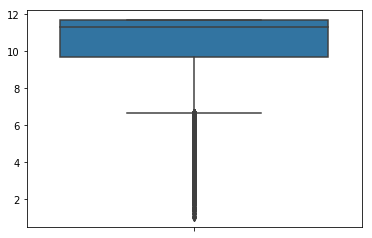

In [26]:
sns.boxplot(y = sorted_idf)

In [27]:
"""Removing Values below 6 and above 10"""
remove_words = {}
for i,j in idf_dict.items():
    if(int(j)<6 or int(j) >10):
        remove_words[i] = idf_dict[i]

In [29]:
"""Removing Words from Data
from tqdm import tqdm

essay_train = project_data_train["essay"]
essay_test = project_data_test["essay"]

stopwords = list(remove_words.keys())

idf_essay_train = []

for query in tqdm(essay_train):
    
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    idf_essay_train.append(result)
    
    
"""

'Removing Words from Data\nfrom tqdm import tqdm\n\nessay_train = project_data_train["essay"]\nessay_test = project_data_test["essay"]\n\nstopwords = list(remove_words.keys())\n\nidf_essay_train = []\n\nfor query in tqdm(essay_train):\n    \n    querywords = query.split()\n    resultwords  = [word for word in querywords if word.lower() not in stopwords]\n    result = \' \'.join(resultwords)\n    idf_essay_train.append(result)\n    \n    \n'

In [ ]:
"""idf_essay_test = []

for query in tqdm(essay_test):
    
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    idf_essay_test.append(result)"""

In [106]:
"""df2_train = pd.DataFrame(idf_essay_train,columns = ["train_essay"])
df2_test = pd.DataFrame(idf_essay_test,columns = ["test_essay"])
df2_train.to_csv(r'lstm_model2_train.csv')
df2_test.to_csv(r"lstm_model2_test.csv")"""

df2_train = pd.read_csv("lstm_model2_train.csv")
df2_test = pd.read_csv("lstm_model2_test.csv")

idf_essay_train= df2_train["train_essay"].astype(str)
idf_essay_test= df2_test["test_essay"].astype(str)

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(idf_essay_train)
vocab_size_idf = len(t.word_index) + 1

In [108]:
# integer encode the documents
#Train
idf_docs_train = t.texts_to_sequences(idf_essay_train)
print(idf_docs_train[1])

[2360, 3424, 3381, 4526, 244]


In [109]:
#Test
idf_docs_test = t.texts_to_sequences(idf_essay_test)
print(idf_docs_test[1])

[370, 9405, 613, 613, 613, 370, 2857, 15363, 731, 987, 12924, 370, 836, 2937, 21536, 2453, 1561, 399, 278, 1773, 2163, 1147, 4067, 1346, 1147, 2761, 21536, 15181, 170]


In [110]:
# truncate and/or pad input sequences
max_review_length = 200
pad_idf_train = pad_sequences(idf_docs_train, maxlen=max_review_length)
pad_idf_test = pad_sequences(idf_docs_test, maxlen=max_review_length)

print(pad_idf_train.shape)
print(pad_idf_train[10])

(87398, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0  414  78

In [111]:
# create a weight matrix for words in training docs
embedding_matrix_idf = np.zeros((vocab_size_idf, 300))
for word, i in t.word_index.items():
    embedding_vector = glovemodel.get(word)
    if embedding_vector is not None:
        embedding_matrix_idf[i] = embedding_vector

In [204]:
tf.keras.backend.clear_session()

Input_model_1 = Input(shape=(max_review_length,) ,name="Text_data")
layer11 = Embedding(vocab_size_idf, 300 ,weights=[embedding_matrix_idf],trainable=False ,name="layer11")(Input_model_1)
layer21 = LSTM(units = 100,activation='relu',kernel_initializer='he_normal',return_sequences = False,name="layer21")(layer11)
layer31 = Flatten()(layer21)

Input_model_2 = Input(shape=(1,),name="School_state")
layer12 = Embedding(state_size + 1, 2 ,name="layer12")(Input_model_2)
layer22 = Flatten()(layer12)

Input_model_3 = Input(shape=(3,),name="Grade")
layer13 = Embedding(grade_size + 1, 2 ,name="layer13")(Input_model_3)
layer23 = Flatten()(layer13)

Input_model_4 = Input(shape=(max_category_length,),name="Categories")
layer14 = Embedding(cate_size + 1, 4 ,name="layer14")(Input_model_4)
layer24 = Flatten()(layer14)

Input_model_5 = Input(shape=(max_subcategory_length,),name="sub_Category")
layer15 = Embedding(subcate_size + 1, 4 ,name="layer15")(Input_model_5)
layer25 = Flatten()(layer15)

Input_model_6 = Input(shape=(1,),name="Prefix")
layer16 = Embedding(prefix_size + 1, 2 ,name="layer16")(Input_model_6)
layer26 = Flatten()(layer16)

Input_model_7 = Input(shape=(2,),name="Remaining_features")
layer27 = Dense(units=8,activation='relu',kernel_initializer="he_normal",name="layer27")(Input_model_7)

concat_layer = concatenate(inputs=[layer31,layer22,layer23,layer24,layer25,layer26,layer27],name="concat")

layer2 = Dense(units=512,activation='relu',kernel_initializer='he_normal',name="layer2")(concat_layer)
norm_1 = BatchNormalization()(layer2)
layer3 = Dropout(0.25)(norm_1)
layer4 = Dense(units=256,activation='relu',kernel_initializer='he_normal',name="layer4")(layer3)
norm_2 = BatchNormalization()(layer4)
layer5 = Dense(units=128,activation='relu',kernel_initializer='he_normal',name="layer5")(norm_2)
norm_3 = BatchNormalization()(layer5)
layer6 = Dense(units=64,activation='relu',kernel_initializer='he_normal',name="layer6")(norm_3)

output = Dense(units=1,activation='sigmoid',kernel_initializer="glorot_uniform",name="output")(layer6)

model = Model(inputs=[Input_model_1,Input_model_2,Input_model_3,Input_model_4,Input_model_5,Input_model_6,Input_model_7],outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_data (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
layer11 (Embedding)             (None, 400, 300)     7017000     Text_data[0][0]                  
__________________________________________________________________________________________________
School_state (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
Grade (InputLayer)              [(None, 3)]          0                                            
______________________________________________________________________________________________

In [146]:
from sklearn.metrics import roc_auc_score
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [147]:
#compile 
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [148]:
from time import time
logs1 = r"C:\Users\Dewang\Desktop\AAIC notes\0.0 Assignments\AAIC classroom Assignments\logs\ex2"
tensorboard = TensorBoard(log_dir = logs1 )

In [149]:
class_weights = {0: 1,
                1: 0.2}

In [150]:
#train
model.fit([pad_idf_train,state_enc_train,grade_enc_train,category_train,subcategory_train,prefix_enc_train,remain_train],y_train,
           batch_size=256,epochs=10,
           validation_data= ([pad_idf_test,state_enc_test,grade_enc_test,category_test,subcategory_test,prefix_enc_test,remain_test],y_test),
           class_weight=class_weights,callbacks = [tensorboard])

Train on 87398 samples, validate on 21850 samples
Epoch 1/10
87398/87398 [==============================] - 273s 3ms/sample - loss: 0.2299 - acc: 0.6048 - auc: 0.5190 - val_loss: 0.6576 - val_acc: 0.8486 - val_auc: 0.5000
Epoch 2/10
87398/87398 [==============================] - 271s 3ms/sample - loss: 0.2246 - acc: 0.6398 - auc: 0.5180 - val_loss: 0.6976 - val_acc: 0.1514 - val_auc: 0.5002
Epoch 3/10
87398/87398 [==============================] - 271s 3ms/sample - loss: 0.2232 - acc: 0.6618 - auc: 0.5192 - val_loss: 0.6093 - val_acc: 0.8486 - val_auc: 0.4998
Epoch 4/10
87398/87398 [==============================] - 271s 3ms/sample - loss: 0.2219 - acc: 0.6815 - auc: 0.5323 - val_loss: 0.6406 - val_acc: 0.8486 - val_auc: 0.5000
Epoch 5/10
87398/87398 [==============================] - 270s 3ms/sample - loss: 0.2210 - acc: 0.6997 - auc: 0.5450 - val_loss: 0.6357 - val_acc: 0.8486 - val_auc: 0.5000
Epoch 6/10
87398/87398 [==============================] - 273s 3ms/sample - loss: 0.2204 -

In [56]:
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [57]:
from tensorflow.keras.models import model_from_json
json_file = open('model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model2.h5")
print("Loaded model from disk")

Loaded model from disk


In [58]:
#compile 
loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [59]:
score = loaded_model.evaluate([pad_idf_test,state_enc_test,grade_enc_test,category_test,subcategory_test,prefix_enc_test,remain_test],y_test,
           callbacks = [tensorboard])
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

9600/9600 [==============================] - 73s 8ms/sample - loss: 0.6638 - acc: 0.6085 - auc: 0.6357
Test score: 0.6637970036268235
Test accuracy: 0.60854167


In [77]:
%tensorboard --logdir=logs1 --host localhost --port 8089

'kill' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 8089 (pid 11512), started 0:01:58 ago. (Use '!kill 11512' to kill it.)

# Model 3

## Categorica Features

In [206]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
categories_one_hot = vectorizer.fit_transform(project_data_train['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Shape of matrix after one hot encodig  (87398, 9)


In [207]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(project_data_train['clean_categories'].values)
categories_one_hot_test = vectorizer.transform(project_data_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",categories_one_hot_test.shape)

['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
Shape of matrix after one hot encodig  (21850, 9)


In [208]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer()
sub_categories_one_hot = vectorizer.fit_transform(project_data_train['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
Shape of matrix after one hot encodig  (87398, 30)


In [209]:
# we use count vectorizer to convert the values into one 
vectorizer = CountVectorizer()
vectorizer.fit(project_data_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer.transform(project_data_test['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_test.shape)

['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
Shape of matrix after one hot encodig  (21850, 30)


In [210]:
vectorizer = CountVectorizer()
school_state_one_hot = vectorizer.fit_transform(project_data_train['school_state'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encodig  (87398, 51)


In [211]:
vectorizer = CountVectorizer()
vectorizer.fit(project_data_train['school_state'].values)
print(vectorizer.get_feature_names())
school_state_one_hot_test = vectorizer.transform(project_data_test['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot_test.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
Shape of matrix after one hot encodig  (21850, 51)


In [212]:
vectorizer = CountVectorizer()
gra_cat_one_hot = vectorizer.fit_transform(project_data_train['project_grade_category'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",gra_cat_one_hot.shape)

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Shape of matrix after one hot encodig  (87398, 4)


In [213]:
vectorizer = CountVectorizer()
vectorizer.fit(project_data_train['project_grade_category'].values)
print(vectorizer.get_feature_names())
gra_cat_one_hot_test = vectorizer.transform(project_data_test['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",gra_cat_one_hot_test.shape)

['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
Shape of matrix after one hot encodig  (21850, 4)


In [214]:
vectorizer = CountVectorizer()
tea_pre_one_hot = vectorizer.fit_transform(project_data_train['teacher_prefix'].values.astype('str'))
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",tea_pre_one_hot.shape)

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encodig  (87398, 5)


In [215]:
vectorizer = CountVectorizer()
vectorizer.fit(project_data_train['teacher_prefix'].values.astype('str'))
tea_pre_one_hot_test = vectorizer.transform(project_data_test['teacher_prefix'].values.astype('str'))
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",tea_pre_one_hot_test.shape)

['dr', 'mr', 'mrs', 'ms', 'teacher']
Shape of matrix after one hot encodig  (21850, 5)


### Concating Numerical and Categorical Features

In [216]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(school_state_one_hot.shape)
print(gra_cat_one_hot.shape)
print(tea_pre_one_hot.shape)
print(remain_train.shape)

(87398, 9)
(87398, 30)
(87398, 51)
(87398, 4)
(87398, 5)
(87398, 2)


In [217]:
from scipy.sparse import hstack
concat_train = hstack((categories_one_hot,sub_categories_one_hot,school_state_one_hot,gra_cat_one_hot,tea_pre_one_hot, remain_train))
concat_train.shape

(87398, 101)

In [218]:
from scipy.sparse import hstack
concat_test = hstack((categories_one_hot_test,sub_categories_one_hot_test,school_state_one_hot_test,gra_cat_one_hot_test,tea_pre_one_hot_test, remain_test))
concat_test.shape

(21850, 101)

In [219]:
concat_array_train = concat_train.toarray()
concat_array_test = concat_test.toarray()
nrows, ncols = concat_array_train.shape

In [240]:
tf.keras.backend.clear_session()

Input_model_1 = Input(shape=(max_review_length,) ,name="Text_data")
layer11 = Embedding(vocab_size, 300 ,weights=[embedding_matrix],trainable=False ,name="layer11")(Input_model_1)
layer21 = LSTM(units = 100,activation='relu',kernel_initializer='he_normal',return_sequences = False,name="layer21")(layer11)
layer41 = Flatten()(layer21)

Input_model_2 = Input(shape=(ncols,),name="Concat_input")
layer12 = Embedding(ncols + 1, 16 ,name="layer12")(Input_model_2)
layer22 = Conv1D(64, kernel_size = 10, activation='relu' ,name="layer22")(layer12)
pool_1 =  MaxPooling1D(pool_size=2)(layer22)
layer32 = Conv1D(32, kernel_size = 10, activation='relu' ,name="layer32")(pool_1)
layer42 = Flatten()(layer32)

concat_layer = concatenate(inputs=[layer41,layer42],name="concat")

layer2 = Dense(units=512,activation='relu',kernel_initializer='he_normal',name="layer2")(concat_layer)
norm_1 = BatchNormalization()(layer2)
layer3 = Dropout(0.25)(norm_1)
layer4 = Dense(units=256,activation='relu',kernel_initializer='he_normal',name="layer4")(layer3)
norm_2 = BatchNormalization()(layer4)
layer5 = Dense(units=128,activation='relu',kernel_initializer='he_normal',name="layer5")(norm_2)
norm_3 = BatchNormalization()(layer5)
layer6 = Dense(units=64,activation='relu',kernel_initializer='he_normal',name="layer6")(norm_3)

output = Dense(units=1,activation='sigmoid',kernel_initializer="glorot_uniform",name="output")(layer6)

model = Model(inputs=[Input_model_1,Input_model_2],outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Concat_input (InputLayer)       [(None, 101)]        0                                            
__________________________________________________________________________________________________
layer12 (Embedding)             (None, 101, 16)      1632        Concat_input[0][0]               
__________________________________________________________________________________________________
Text_data (InputLayer)          [(None, 400)]        0                                            
__________________________________________________________________________________________________
layer22 (Conv1D)                (None, 92, 64)       10304       layer12[0][0]                    
______________________________________________________________________________________________

In [241]:
from sklearn.metrics import roc_auc_score
def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [242]:
#compile 
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [243]:
from time import time
logs2 = r"C:\Users\Dewang\Desktop\AAIC notes\0.0 Assignments\AAIC classroom Assignments\logs\ex3"
tensorboard = TensorBoard(log_dir = logs2 )

In [244]:
class_weights = {0: 1,
                1: 0.2}

In [245]:
#train
model.fit([pad_docs_train, concat_array_train],y_train,
           batch_size=256,epochs=10,
           validation_data= ([pad_docs_test,concat_array_test],y_test),class_weight = class_weights
         ,callbacks = [tensorboard])

Train on 87398 samples, validate on 21850 samples
Epoch 1/10
87398/87398 [==============================] - 546s 6ms/sample - loss: 0.2305 - acc: 0.5756 - auc: 0.5344 - val_loss: 0.6402 - val_acc: 0.8486 - val_auc: 0.5170
Epoch 2/10
87398/87398 [==============================] - 546s 6ms/sample - loss: 0.2204 - acc: 0.6201 - auc: 0.5768 - val_loss: 0.6936 - val_acc: 0.5209 - val_auc: 0.5219
Epoch 3/10
87398/87398 [==============================] - 558s 6ms/sample - loss: 0.2169 - acc: 0.6335 - auc: 0.6068 - val_loss: 0.6650 - val_acc: 0.8414 - val_auc: 0.5246
Epoch 4/10
87398/87398 [==============================] - 527s 6ms/sample - loss: 0.2147 - acc: 0.6387 - auc: 0.6239 - val_loss: 0.6180 - val_acc: 0.8486 - val_auc: 0.5431
Epoch 5/10
87398/87398 [==============================] - 528s 6ms/sample - loss: 0.2129 - acc: 0.6458 - auc: 0.6352 - val_loss: 0.6631 - val_acc: 0.8078 - val_auc: 0.5630
Epoch 6/10
87398/87398 [==============================] - 526s 6ms/sample - loss: 0.2112 -

In [246]:
model_json = model.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model3.h5")
print("Saved model to disk")



Saved model to disk


In [247]:
from tensorflow.keras.models import model_from_json
json_file = open('model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model3.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
#compile 
loaded_model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ["accuracy", auc])

In [ ]:
score = loaded_model.evaluate([pad_idf_test,state_enc_test,grade_enc_test,category_test,subcategory_test,prefix_enc_test,remain_test],y_test,
           callbacks = [tensorboard])
print('Test score:', score[0]) 
print('Test accuracy:', score[1])